# A. Attractor reconstruction

In [1]:
import os
import numpy as np
import warnings
warnings.simplefilter('ignore')

os.chdir('../')
from lib.methods import *

fig = Figure_BCVVFC({
                    'font.family':'Times New Roman',
                    'mathtext.fontset':'stix',
                    'font.size':30,
                    })

fig_ = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30,
            })

2023-04-16 20:21:02.517834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
os.chdir('../')

In [3]:
CSV_FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
VIDEO_FILE_DIR = './data/VF_FVF_DATASETS/VIDEO/'
DATA_NAME = 'MRI8_NVF4_10mm_0p2mmVVV'
CSV_SAMPLE_SPAN = (15000, 127000)

FILTERING_CSV_METHODS = 'bandpass_filtering'
BANDPASS_FILTERING_PARAMS = {
                            'passband_edge_freq':[90, 200], 
                            'stopband_edge_freq':[20, 450], 
                            'passband_edge_max_loss':1, 
                            'stopband_edge_min_loss':10
                            }

BIFURCATION_CONVERT_PARAMS = { 
                            'parameter_sample_step': 1000,
                            'standardize': False, 
                            'mean0':True 
                            }
BIFURCATION_DISCRETIZATION_PARAMS = {
                                    'upside_down': True,
                                    'prominence': 0.1 
                                    }

## Load csv data

In [4]:
[mic_t_data, mic_data, flow_data] = LoadCSV(
                                            file_path=CSV_FILE_DIR+DATA_NAME+'.csv', 
                                            data_name_list=['t', 'mic', 'flow'], 
                                            sample_span=CSV_SAMPLE_SPAN
                                            )

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI8_NVF4_10mm_0p2mmVVV.csv
data list | t, mic, flow


In [5]:
pp = PreProcessing(
                data=mic_data,
                t_data=mic_t_data,
                video_data_list=[], 
                video_t_data_list=[]
                )
pp.filter(
            method=FILTERING_CSV_METHODS, 
            params=BANDPASS_FILTERING_PARAMS
            )

### Unit conversion (flow_data [V] --> flow_data [l/min])
conversion_param = 40.
flow_data = flow_data*conversion_param

mic_data = pp.data
mic_t_data = pp.t_data

## Bifurcation convert

In [6]:
BC_mic = BifurcationConvert(
                            data=mic_data, 
                            parameter_data=flow_data, 
                            t_data=mic_t_data
                            )
BC_mic.convert(params=BIFURCATION_CONVERT_PARAMS)
BC_mic.discretization(params = { 'upside_down': False,'prominence': 0.01 })

bifurcation_parameter_mic_list = BC_mic.bifurcation_parameter_list
bifurcation_data_mic_list = BC_mic.bifurcation_data_list
bifurcation_data_mic_list_discreted = BC_mic.bifurcation_data_list_discreted

In [7]:
num = 48

TDE_mic = TimeDelayEmbedding(
                            data=bifurcation_data_mic_list[num], 
                            lags_num=1000, 
                            bins=32
                            )
mutual_info, mutual_info_min = TDE_mic.mutual_information()
print(mutual_info_min)
print('tau = '+str(mutual_info_min*(mic_t_data[1]-mic_t_data[0])*1000)+' [ms]')

20
tau = 1.6000000000016001 [ms]


In [8]:
num = 110

TDE_mic = TimeDelayEmbedding(
                            data=bifurcation_data_mic_list[num], 
                            lags_num=1000, 
                            bins=32
                            )
mutual_info, mutual_info_min = TDE_mic.mutual_information()
print(mutual_info_min)
print('tau = '+str(mutual_info_min*(mic_t_data[1]-mic_t_data[0])*1000)+' [ms]')

22
tau = 1.7600000000017602 [ms]


In [9]:
num = 48

print('mu = '+str(np.mean(bifurcation_parameter_mic_list[num]))+' [l/min]')

mu = 10.000701904296875 [l/min]


In [10]:
num = 111

print('mu = '+str(np.mean(bifurcation_parameter_mic_list[num]))+' [l/min]')

mu = 19.88460693359375 [l/min]


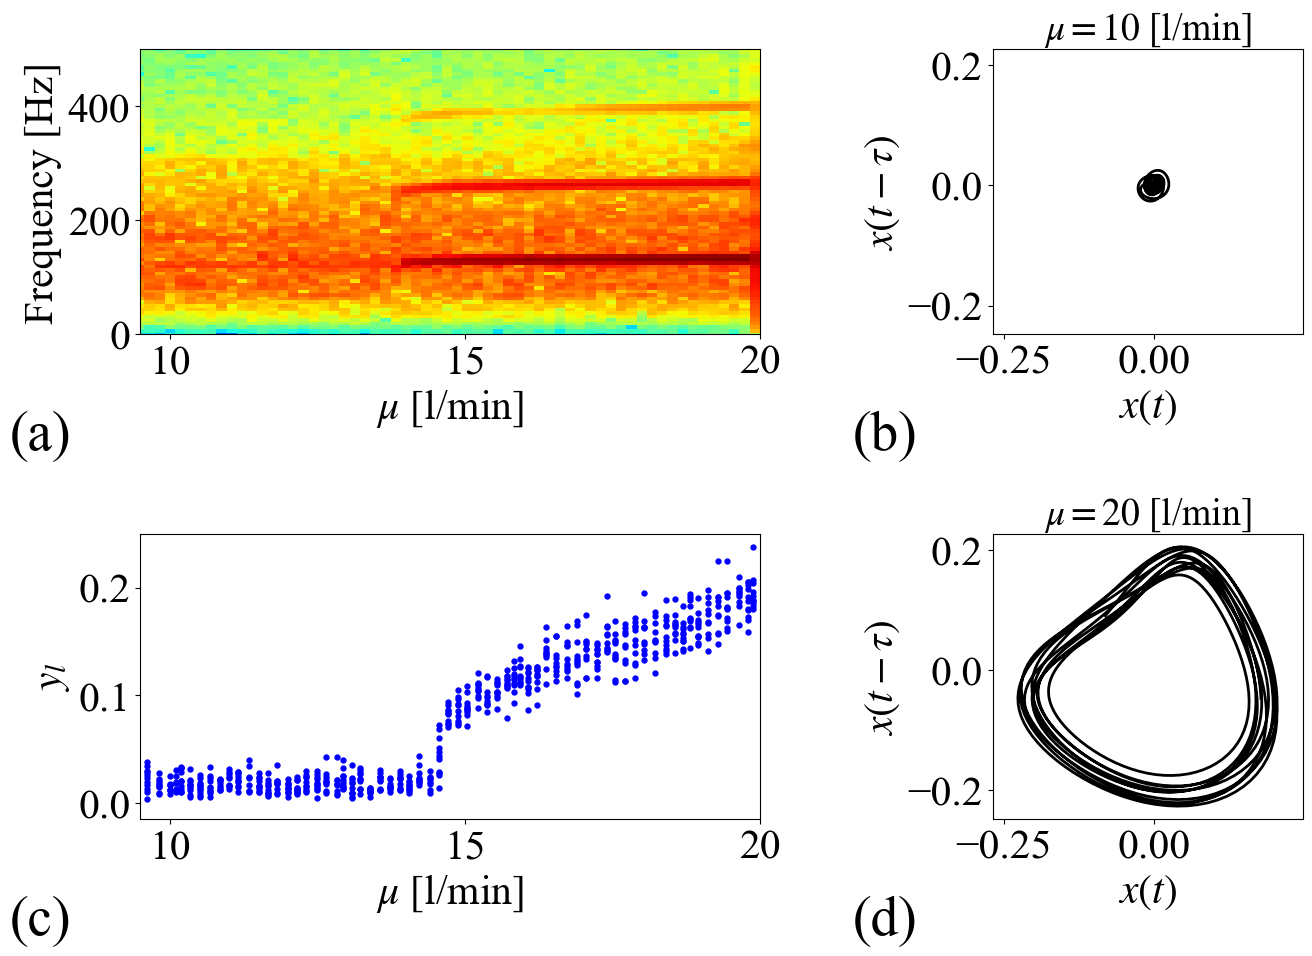

In [14]:
at1 = 48
n_shift_at1 = 20
at2 = 110
n_shift_at2 = 22

fig.figure02_2(data=mic_data[:], t_data=mic_t_data[:],
                data_at1=bifurcation_data_mic_list[at1], n_shift_at1=n_shift_at1, n_plot_at1=None,
                data_at2=bifurcation_data_mic_list[at2], n_shift_at2=n_shift_at2, n_plot_at2=None,
                parameter_data=flow_data[:], 
                data_bf=bifurcation_data_mic_list_discreted, parameter_data_bf=bifurcation_parameter_mic_list, parameter_lim_bf=(9.5, 20),
                figsize=(15, 10), width_ratios=[2, 1], wspace=0.5, hspace=0.7, title_size=27,
                xlabel=r'$\mu$'+' [l/min]', ylabel='Frequency [Hz]', nperseg=2000, cmaplim=(-220, 80), cmap='jet',  xlim=(9.5, 20), ylim=(0, 500), 
                title_at1=r'$\mu=10$'+' [l/min]', title_at2=r'$\mu=20$'+' [l/min]', linestyle_at='-', c_at='k', lw_at=2, xlabel_at=r'$x(t)$', ylabel_at=r'$x(t-\tau)$', same_lim=True,
                marker_bf='.', c_bf='b', s_bf=50, xlabel_bf=r'$\mu$'+' [l/min]', ylabel_bf=r'$y_l$',
                panel_list = ['(a)', '(b)', '(c)', '(d)'], panel_xy_list=[(0.5, 0.4), (0.3, 0.4), (0.5, 0.4), (0.3, 0.4)], panel_fontsize=40, 
                save_filename='results/figure/figure02.png')